# Test IIR coefficients determination

In [1]:
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt

from pathlib import Path
from numpy import convolve
from scipy.signal import lfilter, lfilter_zi
from scipy.optimize import least_squares
from cryoscope_scripts import load_cryoscope_data
from IIR import (
    step,
    inverse_model_IIR,
    residuals_inverse_IIR,
    multi_exponential_IIR,
    residuals_multi_exponential,
    single_exp_params,
    iter_filter_application
)

from tools import (
    plot_signal_filtered,
    plot_reconstructed_data,
    plot_signal_filtered_iter,
    Signal,
)

from qibocal.protocols.two_qubit_interaction.cryoscope import _fit

FLUX_AMPLITUDE = 0.5
SAMPLING_RATE = 1
DIRECT = False
ITERATIONS = 5

[Qibo 0.2.12|INFO|2024-12-16 21:50:29]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-16 21:50:29]: Loading platform dummy


In [2]:
data_path = Path.cwd().parent / "cryo_material" / "long_acquisition" / "data" / "cryoscope-0"
data_json = data_path / "data.json"

with open(data_json, "rb") as file:
    data = json.load(file)

flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz", FLUX_AMPLITUDE)

In [3]:
cryoscope_results = _fit(cryoscope_data)

In [4]:
t = np.arange(0,89,1)
start = 0

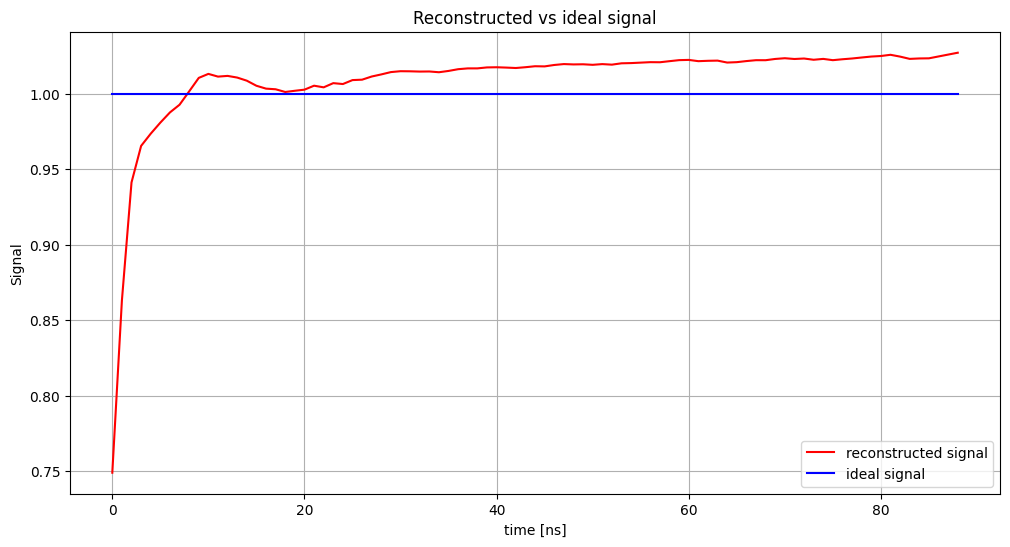

In [5]:
plot_reconstructed_data(cryoscope_results, "D1", 10, t, start)

**Testing parameters conversion for a single fit**

In [6]:
with open("single_IIR_ones.pkl", "rb") as pickle_file:
    result = pickle.load(pickle_file)

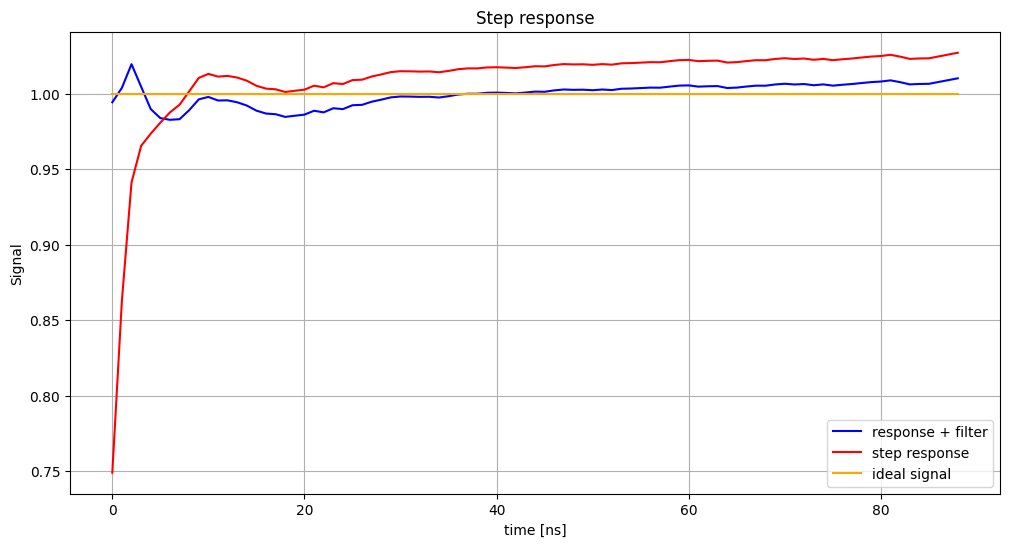

In [7]:
step_response = cryoscope_results.step_response["D1"][10:]

filtered_response = Signal(
    signal=inverse_model_IIR(result.x, t, start, step_response),
    label="response + filter",
)
response = Signal(signal=step_response, label="step response")

plot_signal_filtered(filtered_response, response, t, start)

In [8]:
a, b = single_exp_params(result.x, SAMPLING_RATE)

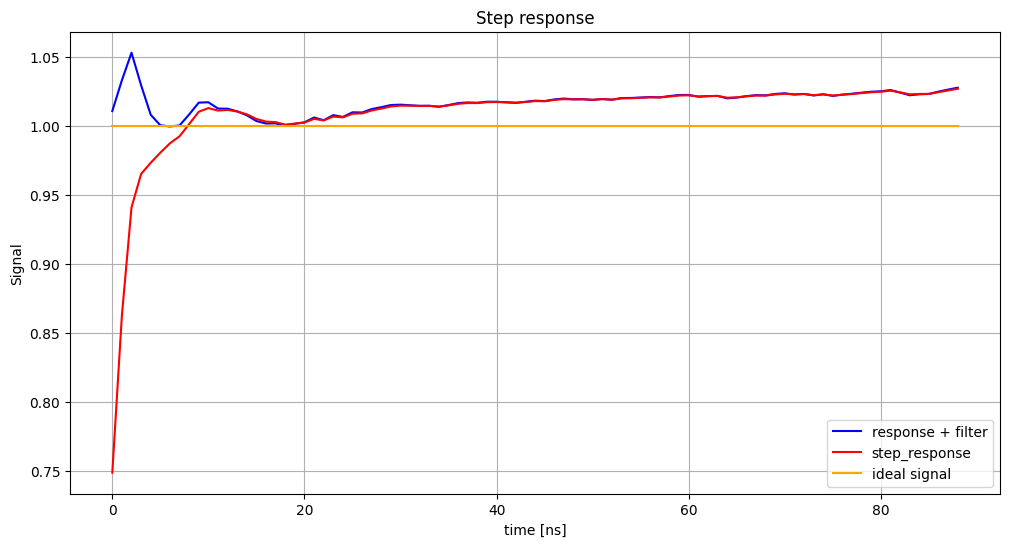

In [9]:
#apply filter without zi

filtered_signal = lfilter(b, a, step_response)

filtered_response =  Signal(filtered_signal, label="response + filter")
response = Signal(step_response, label="step_response")

plot_signal_filtered(filtered_response, response, t, start)

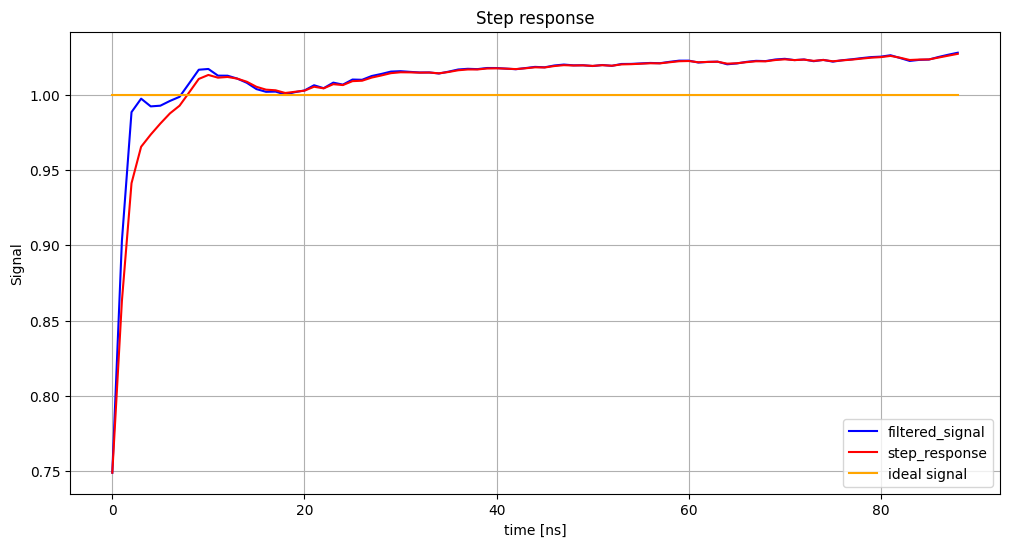

In [10]:
#apply filter with zi
zi = lfilter_zi(b,a)*step_response[0]
filtered_signal, _ = lfilter(b, a, step_response, zi=zi)

filtered_response = Signal(filtered_signal, label="filtered_signal")

plot_signal_filtered(filtered_response, response, t, start)

**Code for filter application iteration**

In [11]:
init_guess = [1, 1, 1]

responses, results = iter_filter_application(
    DIRECT, ITERATIONS, t, start, init_guess, step_response
)

with open("5IIR_inverse_ones.pkl", "wb") as pickle_file:
    pickle.dump(results, pickle_file)

/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:21: RuntimeWarning: overflow encountered in exp
  return data / (g * (1 + A * np.exp(-(t - start) / tau)))


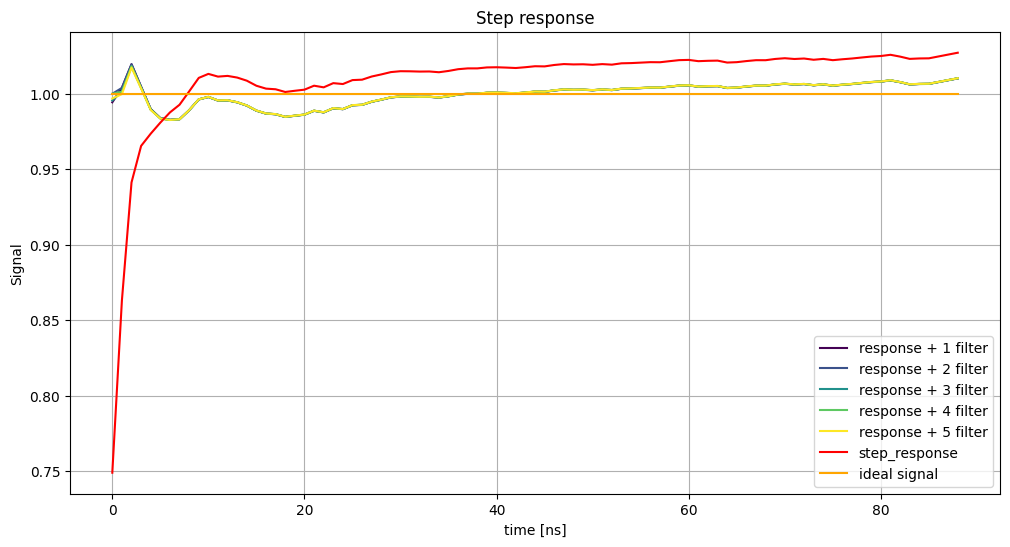

In [12]:
filtered_responses = []
for i in range(5):
    filtered = Signal(responses[i], f"response + {i+1} filter")
    filtered_responses.append(filtered)

plot_signal_filtered_iter(filtered_responses, response, t, start)

In [13]:
for result in results:
    print(result.x)

[ 1.01678789  1.9324137  -0.25922678]
[ 1.00006418  0.04952302 -0.00574361]
[0.99988383 1.69321143 0.00459878]
[ 1.00005048  0.0249821  -0.0045124 ]
[0.9999222  1.58098523 0.00323959]


In [14]:
#to be fixed

b_total = [1]
a_total = [1]

for result in results:
    params = result.x
    a, b = single_exp_params(params, 1)
    b_total = convolve(b_total, b)
    a_total = convolve(a_total, a)

print(a_total)
print(b_total)


[ 1.00000000e+00 -1.58512941e+00  8.36686325e-01 -1.47055950e-01
  2.22471627e-10  0.00000000e+00]
[nan nan nan nan nan nan]


/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  k = A / ((1 + A) * (1 - alpha)) if A < 0 else A / (1 + A - alpha)
/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:70: RuntimeWarning: invalid value encountered in scalar add
  b0 = 1 - k + k * alpha
/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:71: RuntimeWarning: invalid value encountered in scalar multiply
  b1 = -(1 - k) * (1 - alpha)
